[View in Colaboratory](https://colab.research.google.com/github/waelkedi/IA/blob/master/TP1/TP1.ipynb)

# 1. Importation des librairies

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from keras.applications.xception import Xception, preprocess_input
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.losses import categorical_crossentropy
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import math
import numpy as np
import os
import argparse
import matplotlib
import imghdr
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle as pkl
import datetime

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87

# 2. Génération des données à partir de chemins

In [0]:
def generate_from_paths_and_labels(input_paths, labels, batch_size, input_size=(299,299)):

    num_samples = len(input_paths)
    while 1:
        perm = np.random.permutation(num_samples)
        input_paths = input_paths[perm]
        labels = labels[perm]
        for i in range(0, num_samples, batch_size):
            inputs = list(map(
                lambda x: image.load_img(x, target_size=input_size),
                input_paths[i:i+batch_size]
            ))
            inputs = np.array(list(map(
                lambda x: image.img_to_array(x),
                inputs
            )))
            inputs = preprocess_input(inputs)
            yield (inputs, labels[i:i+batch_size])

# 3. Définition des paramètres

In [0]:
# paramètres
lr_pre=1e-3
lr_fine=1e-4
epochs_fine = 5
batch_size_fine=8
dataset_path = "data_small"
result_path = "result"
classes_path = "classes.txt"
snapshot_period_pre=1
snapshot_period_fine=1

# 4. Récupérer les images ainsi que leurs classes

In [5]:
cd /content/gdrive/My\ Drive

/content/gdrive/My Drive


In [6]:
ls

classes.txt       data_big/   data_deep.7z  data_small/   model
Colab Notebooks/  data_deep/  data_medium/  images_test/  result/


In [0]:
# Récupurer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# Récupurer les images et les classes
input_paths, labels = [], []
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    class_id = classes.index(class_name)
    for path in os.listdir(class_path):
        path = os.path.join(class_path, path)
        if imghdr.what(path) == None:
            # this is not an image file
            continue
        input_paths.append(path)
        labels.append(class_id)

# 5. Préparer les données

In [8]:
# convert labels to one-hot-vector format
labels = to_categorical(labels)

# convert input paths to numpy array
input_paths = np.array(input_paths)


# shuffle dataset (permuter les données)
perm = np.random.permutation(len(input_paths))
labels = labels[perm]
input_paths = input_paths[perm]

# split dataset for training and validation
border = int(len(input_paths) * 0.8)
train_labels, val_labels = labels[:border], labels[border:]
train_input_paths, val_input_paths = input_paths[:border], input_paths[border:]
print("Training on %d images and labels" % (len(train_input_paths)))
print("Validation on %d images and labels" % (len(val_input_paths)))

# Création du dossier pour sauvegrader le model
if os.path.exists(result_path) == False:
    os.makedirs(result_path)

Training on 480 images and labels
Validation on 120 images and labels


# 6. Choix et création du classifieur

In [0]:
base_model = Xception(include_top=False, weights='imagenet', input_shape=(299,299,3))  # La pouvez tester différentes architectures

# create a custom top classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

# 7. Entrainer le modèle

In [26]:
# ====================================================
# Train the whole model
# ====================================================
# set all the layers to be trainable
for layer in model.layers:
    layer.trainable = True

# recompiler

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Lancer l'entrainement
#generator = generate_from_paths_and_labels(input_paths, labels, 10)
#model.fit_generator(generator,steps_per_epoch=10)


hist_pre = model.fit_generator(generator = generate_from_paths_and_labels(train_input_paths,train_labels, batch_size_fine),
    steps_per_epoch=1,
    epochs=1,
    validation_data= generate_from_paths_and_labels(val_input_paths,val_labels, batch_size_fine),
    validation_steps=1,
    verbose=1                
)

# Sauvegarder le modèle (model.save)

model.save("model")


Epoch 1/1
1/1 [==============================] - 41s 41s/step - loss: 0.0650 - acc: 1.0000 - val_loss: 8.9781e-05 - val_acc: 1.0000


# 8. Créer et afficher les résultats

In [0]:
hist_fine = hist_pre

ValueError: ignored

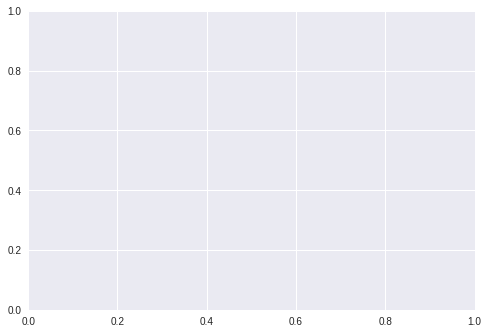

In [38]:
# ====================================================
# Create & save result graphs
# ====================================================
# concatinate plot data
acc = hist_pre.history['acc']
val_acc = hist_pre.history['val_acc']
loss = hist_pre.history['loss']
val_loss = hist_pre.history['val_loss']
acc.extend(hist_fine.history['acc'])
val_acc.extend(hist_fine.history['val_acc'])
loss.extend(hist_fine.history['loss'])
val_loss.extend(hist_fine.history['val_loss'])

# save graph image
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig(os.path.join(result_path, 'acc.png'))
plt.clf()

plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(os.path.join(result_path, 'loss.png'))
plt.clf()

# save plot data as pickle file
plot = {
    'acc': acc,
    'val_acc': val_acc,
    'loss': loss,
    'val_loss': val_loss,
}
with open(os.path.join(result_path, 'plot.dump'), 'wb') as f:
    pkl.dump(plot, f) 

# 9. Tester le modèle

In [0]:
from keras.applications.xception import (
    Xception, preprocess_input, decode_predictions
)
from matplotlib import pyplot as plt
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
import os
import cv2 

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

%matplotlib inline

model_path="result/model_fine_final.h5"   # Ici, vous devez indiquer votre modèle
classes_path = "classes.txt"
image_path="images_test/feu3.jpg"         # Votre image de test   
top_n=3
model = load_model(model_path)

# load class names
classes = []
with open(classes_path, 'r') as f:
    classes = list(map(lambda x: x.strip(), f.readlines()))

# load an input image
img = image.load_img(image_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# predict
pred = model.predict(x)[0]
result = [(classes[i], float(pred[i]) * 100.0) for i in range(len(pred))]
result.sort(reverse=True, key=lambda x: x[1])

img = cv2.imread(image_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.rectangle(img, (200,200), (800,500), (0,0,0), 4)

font = cv2.FONT_HERSHEY_COMPLEX 

for i in range(top_n):
    (class_name, prob) = result[i]
    if (i == 0) :
        cv2.putText(img, class_name, (250, 400), font, 5, (255,0,0), 6, cv2.LINE_AA)
    print("Top %d ====================" % (i + 1))
    print("Class name: %s" % (class_name))
    print("Probability: %.2f%%" % (prob))
plt.imshow(img)